In [1]:
import numpy as np
import xarray as xr
import dask.array as dsar
import xrft

In [2]:
def _synthetic_field(N, dL, amp, s):
    """
    Generate a synthetic series of size N by N
    with a spectral slope of s.
    """

    k = np.fft.fftshift(np.fft.fftfreq(N, dL))
    l = np.fft.fftshift(np.fft.fftfreq(N, dL))
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2+ll**2)

    ########
    # amplitude
    ########
    r_kl = np.ma.masked_invalid(np.sqrt(amp*.5*(np.pi)**(-1)
                                *K**(s-1.))).filled(0.)
    ########
    # phase
    ########
    phi = np.zeros((N, N))

    N_2 = int(N/2)
    phi_upper_right = 2.*np.pi*np.random.random((N_2-1,
                                                 N_2-1)) - np.pi
    phi[N_2+1:,N_2+1:] = phi_upper_right.copy()
    phi[1:N_2, 1:N_2] = -phi_upper_right[::-1, ::-1].copy()


    phi_upper_left = 2.*np.pi*np.random.random((N_2-1,
                                                N_2-1)) - np.pi
    phi[N_2+1:,1:N_2] = phi_upper_left.copy()
    phi[1:N_2, N_2+1:] = -phi_upper_left[::-1, ::-1].copy()


    phi_upper_middle = 2.*np.pi*np.random.random(N_2) - np.pi
    phi[N_2:, N_2] = phi_upper_middle.copy()
    phi[1:N_2, N_2] = -phi_upper_middle[1:][::-1].copy()


    phi_right_middle = 2.*np.pi*np.random.random(N_2-1) - np.pi
    phi[N_2, N_2+1:] = phi_right_middle.copy()
    phi[N_2, 1:N_2] = -phi_right_middle[::-1].copy()


    phi_edge_upperleft = 2.*np.pi*np.random.random(N_2) - np.pi
    phi[N_2:, 0] = phi_edge_upperleft.copy()
    phi[1:N_2, 0] = -phi_edge_upperleft[1:][::-1].copy()


    phi_bot_right = 2.*np.pi*np.random.random(N_2) - np.pi
    phi[0, N_2:] = phi_bot_right.copy()
    phi[0, 1:N_2] = -phi_bot_right[1:][::-1].copy()


    phi_corner_leftbot = 2.*np.pi*np.random.random() - np.pi

    for i in range(1, N_2):
        for j in range(1, N_2):
            assert (phi[N_2+j, N_2+i] == -phi[N_2-j, N_2-i])

    for i in range(1, N_2):
        for j in range(1, N_2):
            assert (phi[N_2+j, N_2-i] == -phi[N_2-j, N_2+i])

    for i in range(1, N_2):
        assert (phi[N_2, N-i] == -phi[N_2, i])
        assert (phi[N-i, N_2] == -phi[i, N_2])
        assert (phi[N-i, 0] == -phi[i, 0])
        assert (phi[0, i] == -phi[0, N-i])
    #########
    # complex fourier amplitudes
    #########
    F_theta = r_kl * np.exp(1j * phi)

    # check that symmetry of FT is satisfied
    theta = np.fft.ifft2(np.fft.ifftshift(F_theta))
    return np.real(theta)

In [3]:
def synthetic_field_xr(N, dL, amp, s,
                    other_dim_sizes=None, dim_order=True, 
                    chunks=None):
    
    theta = xr.DataArray(_synthetic_field(N, dL, amp, s),
                        dims=['y', 'x'],
                        coords={'y':range(N), 'x':range(N)}
                        )

    if other_dim_sizes:
        _da = xr.DataArray(np.ones(other_dim_sizes),
                           dims=['d%d'%i for i in range(len(other_dim_sizes))])
        if dim_order:
            theta = theta + _da
        else:
            theta = _da + theta
            
    if chunks:
        theta = theta.chunk(chunks)

    return theta

In [23]:
N = 512

dL, amp, s = 1., 1e1, -3.
dims = ['x','y']
fftdim = ['freq_' + d for d in dims]    
spacing_tol = 1e-3
nfactor = 4
# np data
theta = synthetic_field_xr(N, dL, amp, s)

ps = xrft.power_spectrum(theta, spacing_tol, dim=dims)
ps = np.sqrt(ps.freq_x**2+ps.freq_y**2)
ps_iso = xrft.isotropize(ps, fftdim, nfactor=nfactor)    

/Users/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


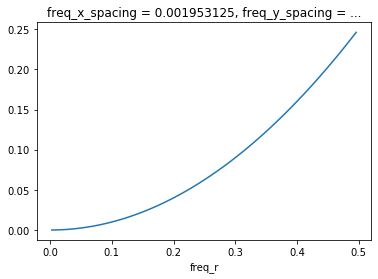

In [25]:
ps_iso.plot()

In [21]:
import numpy.testing as npt

In [34]:
len(ps_iso.dims)

1

In [29]:
ps_iso

<xarray.DataArray (freq_r: 127)>
array([7.62363585e-06, 3.64918272e-05, 9.70923729e-05, 1.87136308e-04,
       3.10906258e-04, 4.68882844e-04, 6.52811370e-04, 8.64433934e-04,
       1.11450034e-03, 1.39422128e-03, 1.69765878e-03, 2.04003491e-03,
       2.41114480e-03, 2.80466889e-03, 3.23936472e-03, 3.70365110e-03,
       4.19663770e-03, 4.72831205e-03, 5.27703736e-03, 5.84742269e-03,
       6.46242305e-03, 7.11526880e-03, 7.80273854e-03, 8.51453245e-03,
       9.23605136e-03, 1.00071106e-02, 1.08212066e-02, 1.16396862e-02,
       1.24978596e-02, 1.34069443e-02, 1.43339121e-02, 1.52671885e-02,
       1.62491905e-02, 1.72805409e-02, 1.83381271e-02, 1.94132035e-02,
       2.05052097e-02, 2.16296930e-02, 2.28083038e-02, 2.40149122e-02,
       2.52475102e-02, 2.65068730e-02, 2.77978823e-02, 2.91140765e-02,
       3.04557918e-02, 3.18469614e-02, 3.32834564e-02, 3.47224121e-02,
       3.61833186e-02, 3.76726717e-02, 3.92106991e-02, 4.08097395e-02,
       4.24218866e-02, 4.40364389e-02, 4.56909289e-02, 4.73770828e-02,
       4.90916996e-02, 5.08478557e-02, 5.26475506e-02, 5.44667427e-02,
       5.63055912e-02, 5.81869091e-02, 6.00933059e-02, 6.20257112e-02,
       6.40007262e-02, 6.60048965e-02, 6.80327085e-02, 7.00896267e-02,
       7.21771062e-02, 7.42922960e-02, 7.64370144e-02, 7.86311671e-02,
       8.08616415e-02, 8.30996771e-02, 8.53495305e-02, 8.76521260e-02,
       9.00042170e-02, 9.23885232e-02, 9.47944998e-02, 9.72124331e-02,
       9.96698317e-02, 1.02159682e-01, 1.04675396e-01, 1.07234358e-01,
       1.09828559e-01, 1.12441763e-01, 1.15073887e-01, 1.17736663e-01,
       1.20433781e-01, 1.23186962e-01, 1.25961307e-01, 1.28768702e-01,
       1.31600150e-01, 1.34444948e-01, 1.37323593e-01, 1.40242423e-01,
       1.43206723e-01, 1.46207187e-01, 1.49214402e-01, 1.52216087e-01,
       1.55288939e-01, 1.58428516e-01, 1.61554224e-01, 1.64719589e-01,
       1.67927035e-01, 1.71134402e-01, 1.74388218e-01, 1.77703529e-01,
       1.81043799e-01, 1.84406782e-01, 1.87775497e-01, 1.91177938e-01,
       1.94612436e-01, 1.98090376e-01, 2.01620550e-01, 2.05158095e-01,
       2.08702922e-01, 2.12298352e-01, 2.15935144e-01, 2.19574556e-01,
       2.23261560e-01, 2.26988141e-01, 2.30741955e-01, 2.34540116e-01,
       2.38336253e-01, 2.42158515e-01, 2.46053886e-01])
Coordinates:
  * freq_r          (freq_r) float64 0.002653 0.006041 0.009854 ... 0.4921 0.496
    freq_x_spacing  float64 0.001953
    freq_y_spacing  float64 0.001953

In [32]:
npt.assert_allclose(ps_iso, ps_iso.freq_r**2, atol=0.02)

In [28]:
ps.freq_x.where(ps.freq_x>0, drop=True)

<xarray.DataArray 'freq_x' (freq_x: 255)>
array([0.00195312, 0.00390625, 0.00585938, 0.0078125 , 0.00976562,
       0.01171875, 0.01367188, 0.015625  , 0.01757812, 0.01953125,
       0.02148438, 0.0234375 , 0.02539062, 0.02734375, 0.02929688,
       0.03125   , 0.03320312, 0.03515625, 0.03710938, 0.0390625 ,
       0.04101562, 0.04296875, 0.04492188, 0.046875  , 0.04882812,
       0.05078125, 0.05273438, 0.0546875 , 0.05664062, 0.05859375,
       0.06054688, 0.0625    , 0.06445312, 0.06640625, 0.06835938,
       0.0703125 , 0.07226562, 0.07421875, 0.07617188, 0.078125  ,
       0.08007812, 0.08203125, 0.08398438, 0.0859375 , 0.08789062,
       0.08984375, 0.09179688, 0.09375   , 0.09570312, 0.09765625,
       0.09960938, 0.1015625 , 0.10351562, 0.10546875, 0.10742188,
       0.109375  , 0.11132812, 0.11328125, 0.11523438, 0.1171875 ,
       0.11914062, 0.12109375, 0.12304688, 0.125     , 0.12695312,
       0.12890625, 0.13085938, 0.1328125 , 0.13476562, 0.13671875,
       0.13867188, 0.140625  , 0.14257812, 0.14453125, 0.14648438,
       0.1484375 , 0.15039062, 0.15234375, 0.15429688, 0.15625   ,
       0.15820312, 0.16015625, 0.16210938, 0.1640625 , 0.16601562,
       0.16796875, 0.16992188, 0.171875  , 0.17382812, 0.17578125,
       0.17773438, 0.1796875 , 0.18164062, 0.18359375, 0.18554688,
       0.1875    , 0.18945312, 0.19140625, 0.19335938, 0.1953125 ,
       0.19726562, 0.19921875, 0.20117188, 0.203125  , 0.20507812,
       0.20703125, 0.20898438, 0.2109375 , 0.21289062, 0.21484375,
       0.21679688, 0.21875   , 0.22070312, 0.22265625, 0.22460938,
       0.2265625 , 0.22851562, 0.23046875, 0.23242188, 0.234375  ,
       0.23632812, 0.23828125, 0.24023438, 0.2421875 , 0.24414062,
       0.24609375, 0.24804688, 0.25      , 0.25195312, 0.25390625,
       0.25585938, 0.2578125 , 0.25976562, 0.26171875, 0.26367188,
       0.265625  , 0.26757812, 0.26953125, 0.27148438, 0.2734375 ,
       0.27539062, 0.27734375, 0.27929688, 0.28125   , 0.28320312,
       0.28515625, 0.28710938, 0.2890625 , 0.29101562, 0.29296875,
       0.29492188, 0.296875  , 0.29882812, 0.30078125, 0.30273438,
       0.3046875 , 0.30664062, 0.30859375, 0.31054688, 0.3125    ,
       0.31445312, 0.31640625, 0.31835938, 0.3203125 , 0.32226562,
       0.32421875, 0.32617188, 0.328125  , 0.33007812, 0.33203125,
       0.33398438, 0.3359375 , 0.33789062, 0.33984375, 0.34179688,
       0.34375   , 0.34570312, 0.34765625, 0.34960938, 0.3515625 ,
       0.35351562, 0.35546875, 0.35742188, 0.359375  , 0.36132812,
       0.36328125, 0.36523438, 0.3671875 , 0.36914062, 0.37109375,
       0.37304688, 0.375     , 0.37695312, 0.37890625, 0.38085938,
       0.3828125 , 0.38476562, 0.38671875, 0.38867188, 0.390625  ,
       0.39257812, 0.39453125, 0.39648438, 0.3984375 , 0.40039062,
       0.40234375, 0.40429688, 0.40625   , 0.40820312, 0.41015625,
       0.41210938, 0.4140625 , 0.41601562, 0.41796875, 0.41992188,
       0.421875  , 0.42382812, 0.42578125, 0.42773438, 0.4296875 ,
       0.43164062, 0.43359375, 0.43554688, 0.4375    , 0.43945312,
       0.44140625, 0.44335938, 0.4453125 , 0.44726562, 0.44921875,
       0.45117188, 0.453125  , 0.45507812, 0.45703125, 0.45898438,
       0.4609375 , 0.46289062, 0.46484375, 0.46679688, 0.46875   ,
       0.47070312, 0.47265625, 0.47460938, 0.4765625 , 0.47851562,
       0.48046875, 0.48242188, 0.484375  , 0.48632812, 0.48828125,
       0.49023438, 0.4921875 , 0.49414062, 0.49609375, 0.49804688])
Coordinates:
  * freq_x          (freq_x) float64 0.001953 0.003906 0.005859 ... 0.4961 0.498
    freq_x_spacing  float64 0.001953
    freq_y_spacing  float64 0.001953

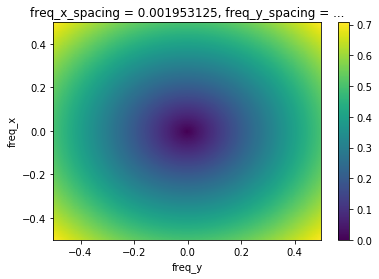

In [20]:
ps.plot()

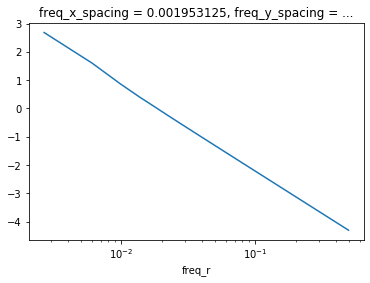

In [11]:
np.log10(ps_iso).plot(xscale='log')

In [4]:
def _radial_wvnum(k, l, N, nfactor):
    """ Creates a radial wavenumber based on two horizontal wavenumbers
    along with the appropriate index map
    """
    
    # compute target wavenumbers
    k = k.values
    l = l.values
    K = np.sqrt(k[np.newaxis,:]**2 + l[:,np.newaxis]**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    # compute bin index
    kidx = np.digitize(np.ravel(K), ki)
    # compute number of points for each wavenumber
    area = np.bincount(kidx)
    # compute the average radial wavenumber for each bin
    kr = np.bincount(kidx, weights=K.ravel()) \
            / np.ma.masked_where(area==0, area)

    #return kidx, area, kr
    return ki, kr


def _azimuthal_avg(kidx, f, area, kr):
    """
    Takes the azimuthal average of a given field.
    """
    
    if type(f)==dsar.core.Array:
        _bincount = np.bincount(dsar.from_array(kidx), weights=f)        
    else:
        _bincount = np.bincount(kidx, weights=f)
    if type(_bincount)==dsar.core.Array:
        # required for python 2.7 
        _bincount = _bincount.compute()
        # the shape of _bincount is (nan,) if we don't compute
        # which breaks the divisions below with for example:
        # ValueError: operands could not be broadcast together with shapes (nan,) (65,)

    #iso_f = np.ma.masked_invalid(_bincount / area) * kr
    iso_f = _bincount / np.ma.masked_where(area==0, area) * kr

    return iso_f

def _azi_wrapper(M, kidx, f, area, kr):
    iso = np.zeros(M)
    if len(M) == 1:
        iso = _azimuthal_avg(kidx, f, area, kr)
    elif len(M) == 2:
        for j in range(M[0]):
            iso[j] = _azimuthal_avg(kidx, f[j], area, kr)
    elif len(M) == 3:
        for j in range(M[0]):
            for i in range(M[1]):
                iso[j,i] = _azimuthal_avg(kidx, f[j,i], area, kr)
    else:
        raise ValueError("Arrays with more than 4 dimensions are not supported.")

    return iso

def isotropize(ps, fftdim, nfactor=4):
    """
    Isotropize a 2D power spectrum or cross spectrum 
    by taking an azimuthal average.

    .. math::
        \text{iso}_{ps} = k_r N^{-1} \sum_{N} |\mathbb{F}(da')|^2

    where :math:`N` is the number of azimuthal bins.
    
    Parameters
    ----------
    ps : `xarray.DataArray`
        The power spectrum or cross spectrum to be isotropized.
    fftdim : list
        The fft dimensions overwhich the isotropization must be performed.
    nfactor : int, optional
        Ratio of number of bins to take the azimuthal averaging with the
        data size. Default is 4.        
    """    

    k = ps[fftdim[1]]
    l = ps[fftdim[0]]

    N = [k.size, l.size]
    #M = [ps[d].size for d in ps.dims if d not in fftdim]
    #shape = list(M)

    #kidx, area, kr = _radial_wvnum(k, l, min(N), nfactor)
    ki, kr = _radial_wvnum(k, l, min(N), nfactor)
    
    ps = ps.assign_coords(kreq_r=np.sqrt(k**2+l**2))
    #print(ps)
    iso_ps = ps.groupby_bins('kreq_r', bins=ki, labels=kr).mean()
    #[f.values.item().mid for f in ps.kreq_r_bins]
    
    if False:
        M.append(len(kr))
        shape.append(np.prod(N))

        _ax = [ps.get_axis_num(d) for d in ps.dims if d not in fftdim]+ \
                [ps.get_axis_num(d) for d in fftdim]
        f = ps.data.transpose(*_ax).reshape(shape)

        iso_ps = _azi_wrapper(M, kidx, f, area, kr)
        k_coords = {'freq_r': kr}

        newdims = [d for d in ps.dims if d not in fftdim]
        newdims.append('freq_r')

        newcoords = {}
        for d in newdims:
            if d in ps.coords:
                newcoords[d] = ps.coords[d].values
            elif d in k_coords:
                newcoords[d] = k_coords[d]

        return xr.DataArray(iso_ps, dims=newdims, coords=newcoords)
    
    return iso_ps


def isotropic_power_spectrum(da, spacing_tol=1e-3, dim=None, shift=True,
                           detrend=None, density=True, window=False, nfactor=4):
    """
    Calculates the isotropic spectrum from the
    two-dimensional power spectrum by taking the
    azimuthal average.

    .. math::
        \text{iso}_{ps} = k_r N^{-1} \sum_{N} |\mathbb{F}(da')|^2

    where :math:`N` is the number of azimuthal bins.

    Note: the method is not lazy does trigger computations.

    Parameters
    ----------
    da : `xarray.DataArray`
        The data to be transformed
    spacing_tol: float, optional
        Spacing tolerance. Fourier transform should not be applied to uneven grid but
        this restriction can be relaxed with this setting. Use caution.
    dim : list, optional
        The dimensions along which to take the transformation. If `None`, all
        dimensions will be transformed.
    shift : bool, optional
        Whether to shift the fft output.
    detrend : str, optional
        If `constant`, the mean across the transform dimensions will be
        subtracted before calculating the Fourier transform (FT).
        If `linear`, the linear least-square fit will be subtracted before
        the FT.
    density : list, optional
        If true, it will normalize the spectrum to spectral density
    window : bool, optional
        Whether to apply a Hann window to the data before the Fourier
        transform is taken
    nfactor : int, optional
        Ratio of number of bins to take the azimuthal averaging with the
        data size. Default is 4.

    Returns
    -------
    iso_ps : `xarray.DataArray`
        Isotropic power spectrum
    """

    if dim is None:
        dim = da.dims
    if len(dim) != 2:
        raise ValueError('The Fourier transform should be two dimensional')

    ps = xrft.power_spectrum(da, spacing_tol, dim=dim, shift=shift,
                       detrend=detrend, density=density,
                       window=window)

    fftdim = ['freq_' + d for d in dim]

    return isotropize(ps, fftdim, nfactor=nfactor)

def test_isotropic_ps_slope(N=512, dL=1., amp=1e1, s=-3., **kwargs):
    """Test the spectral slope of isotropic power spectrum."""

    theta = _synthetic_field_xr(N, dL, amp, s, **kwargs)
    
    #return theta
    iso_ps = isotropic_power_spectrum(theta, dim=['y','x'],
                                          detrend='constant',
                                          density=True)
    return iso_ps, theta

out = test_isotropic_ps_slope(other_dim_sizes=[10], dim_order=True)

/Users/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


ValueError: Bin labels must be one fewer than the number of bin edges

In [46]:
[f.values.item().mid for f in out[0].kreq_r_bins]

[0.001325,
 0.004345,
 0.007945,
 0.011775,
 0.01565,
 0.01965,
 0.02365,
 0.0275,
 0.0314,
 0.03535,
 0.03925,
 0.0432,
 0.04715,
 0.05105,
 0.05495,
 0.0589,
 0.06285,
 0.0668,
 0.0707,
 0.07455,
 0.07844999999999999,
 0.0824,
 0.08635000000000001,
 0.09029999999999999,
 0.0942,
 0.09805,
 0.10200000000000001,
 0.106,
 0.11,
 0.114,
 0.118,
 0.122,
 0.1255,
 0.129,
 0.133,
 0.137,
 0.14100000000000001,
 0.145,
 0.149,
 0.153,
 0.157,
 0.161,
 0.165,
 0.169,
 0.173,
 0.1765,
 0.18,
 0.184,
 0.188,
 0.192,
 0.196,
 0.2,
 0.20400000000000001,
 0.208,
 0.212,
 0.216,
 0.22,
 0.2235,
 0.227,
 0.231,
 0.235,
 0.239,
 0.243,
 0.247,
 0.251,
 0.255,
 0.259,
 0.263,
 0.267,
 0.271,
 0.2745,
 0.278,
 0.28200000000000003,
 0.286,
 0.29,
 0.294,
 0.298,
 0.302,
 0.306,
 0.31,
 0.314,
 0.318,
 0.322,
 0.3255,
 0.329,
 0.333,
 0.337,
 0.341,
 0.345,
 0.349,
 0.353,
 0.357,
 0.361,
 0.365,
 0.369,
 0.3725,
 0.376,
 0.38,
 0.384,
 0.388,
 0.392,
 0.396,
 0.4,
 0.404,
 0.40800000000000003,
 0.412,
 0

In [4]:
def test_isotropic_ps_slope(N=512, dL=1., amp=1e1, s=-3., **kwargs):
    """Test the spectral slope of isotropic power spectrum."""

    theta = _synthetic_field_xr(N, dL, amp, s, **kwargs)
    
    #return theta
    iso_ps = xrft.isotropic_power_spectrum(theta, dim=['y','x'],
                                          detrend='constant',
                                          density=True)
    return iso_ps, theta

#test_isotropic_ps_slope(chunks={'y': None, 'x': None, 'd0': 2}, other_dim_sizes=[10], dim_order=True) # breaks
test_isotropic_ps_slope(other_dim_sizes=[10], dim_order=True) # breaks

/Users/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


(<xarray.DataArray (d0: 10, freq_r: 129)>
 array([[0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79555619e+00],
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79555619e+00],
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79555619e+00],
        ...,
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79555619e+00],
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79555619e+00],
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79555619e+00]])
 Coordinates:
   * freq_r   (freq_r) float64 nan nan nan nan nan nan ... nan nan nan nan nan
 Dimensions without coordinates: d0,
 <xarray.DataArray (y: 512, x: 512, d0: 10)>
 array([[[3.80195924, 3.80195924, 3.80195924, ...

In [5]:
test_isotropic_ps_slope()

/Users/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


(<xarray.DataArray (freq_r: 129)>
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
 Coordinates:
   * freq_r   (freq_r) float64 nan nan nan nan nan nan ... nan nan nan nan nan,
 <xarray.DataArray (y: 512, x: 512)>
 array([[-1.77682848, -1.73583125, -1.68431262, ..., -1.912423  ,
         -1.84432993, -1.80525598],
       

In [6]:
test_isotropic_ps_slope(chunks={'y': None, 'x': None})

/Users/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


(<xarray.DataArray (freq_r: 129)>
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
 Coordinates:
   * freq_r   (freq_r) float64 nan nan nan nan nan nan ... nan nan nan nan nan,
 <xarray.DataArray (y: 512, x: 512)>
 dask.array<xarray-<this-array>, shape=(512, 512), dtype=float64, chunksize=(512, 512), chunktype=numpy.ndarr

In [7]:
test_isotropic_ps_slope(other_dim_sizes=[2], chunks={'d0': 2})

/Users/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


(<xarray.DataArray (d0: 2, freq_r: 129)>
 array([[0.00000000e+00, 2.19037945e+06, 2.39834031e+05, 4.77658048e+04,
         1.55748726e+04, 7.91839522e+03, 3.98562434e+03, 2.38618564e+03,
         1.51690508e+03, 1.12925026e+03, 7.31072892e+02, 5.69123795e+02,
         4.34784458e+02, 3.31845988e+02, 2.57389557e+02, 2.23150531e+02,
         1.68748469e+02, 1.49421495e+02, 1.20913012e+02, 1.00533215e+02,
         8.54110583e+01, 7.75032442e+01, 6.53569499e+01, 5.87397483e+01,
         4.89793524e+01, 4.30460053e+01, 4.05552344e+01, 3.48833191e+01,
         3.03247403e+01, 2.86388455e+01, 2.58317637e+01, 2.24773842e+01,
         2.03334515e+01, 1.92388135e+01, 1.75797631e+01, 1.58262575e+01,
         1.44437072e+01, 1.30033343e+01, 1.24137182e+01, 1.14904804e+01,
         1.05750851e+01, 9.75801968e+00, 9.09472311e+00, 8.42659298e+00,
         7.88241212e+00, 7.25531182e+00, 7.09053104e+00, 6.46952016e+00,
         6.00473123e+00, 5.62232751e+00, 5.32345728e+00, 5.08780621e+00,
         4

In [8]:
test_isotropic_ps_slope(other_dim_sizes=[10], chunks={'d0': 2}, dim_order=False)

/Users/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


(<xarray.DataArray (d0: 10, freq_r: 129)>
 array([[0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79562714e+00],
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79562714e+00],
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79562714e+00],
        ...,
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79562714e+00],
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79562714e+00],
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79562714e+00]])
 Coordinates:
   * freq_r   (freq_r) float64 nan nan nan nan nan nan ... nan nan nan nan nan
 Dimensions without coordinates: d0,
 <xarray.DataArray (d0: 10, y: 512, x: 512)>
 dask.array<xarray-<this-array>, shape=(10, 512, 

In [9]:
test_isotropic_ps_slope(chunks={'y': None, 'x': None, 'd0': 2}, other_dim_sizes=[10], dim_order=True)

/Users/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


(<xarray.DataArray (d0: 10, freq_r: 129)>
 array([[0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79560721e+00],
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79560721e+00],
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79560721e+00],
        ...,
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79560721e+00],
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79560721e+00],
        [0.00000000e+00, 2.19037945e+06, 2.39834031e+05, ...,
         3.30082331e-01, 3.21748230e-01, 3.79560721e+00]])
 Coordinates:
   * freq_r   (freq_r) float64 nan nan nan nan nan nan ... nan nan nan nan nan
 Dimensions without coordinates: d0,
 <xarray.DataArray (y: 512, x: 512, d0: 10)>
 dask.array<xarray-<this-array>, shape=(512, 512,